# 01 Most common metrics to analyse relationship between entities in a dataset

- Current application: Weather data

In [4]:
%load_ext autoreload
%autoreload 2
import sys

sys.path.append("../")

import jupyter_black

jupyter_black.load()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import src.cleansing as cleansing

In [15]:
df = pd.read_csv("../data/Weather Data.csv")

# rename columns
# parse datetime column
df = cleansing.clean_weather_data(df)

In [31]:
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer
from statsmodels.tsa.seasonal import seasonal_decompose

In [21]:
df.set_index("date_time", inplace=True)

In [23]:
df

,temp_c,dew_point_temp_c,real_hum_pct,wind_speed_kmh,visibility_km,press_kpa,weather
date_time,,,,,,,
2012-01-01 00:00:00,-1.8,-3.9,86,4,8.0,101.24,Fog
2012-01-01 01:00:00,-1.8,-3.7,87,4,8.0,101.24,Fog
2012-01-01 02:00:00,-1.8,-3.4,89,7,4.0,101.26,"Freezing Drizzle,Fog"
2012-01-01 03:00:00,-1.5,-3.2,88,6,4.0,101.27,"Freezing Drizzle,Fog"
2012-01-01 04:00:00,-1.5,-3.3,88,7,4.8,101.23,Fog
...,...,...,...,...,...,...,...
2012-12-31 19:00:00,0.1,-2.7,81,30,9.7,100.13,Snow
2012-12-31 20:00:00,0.2,-2.4,83,24,9.7,100.03,Snow
2012-12-31 21:00:00,-0.5,-1.5,93,28,4.8,99.95,Snow


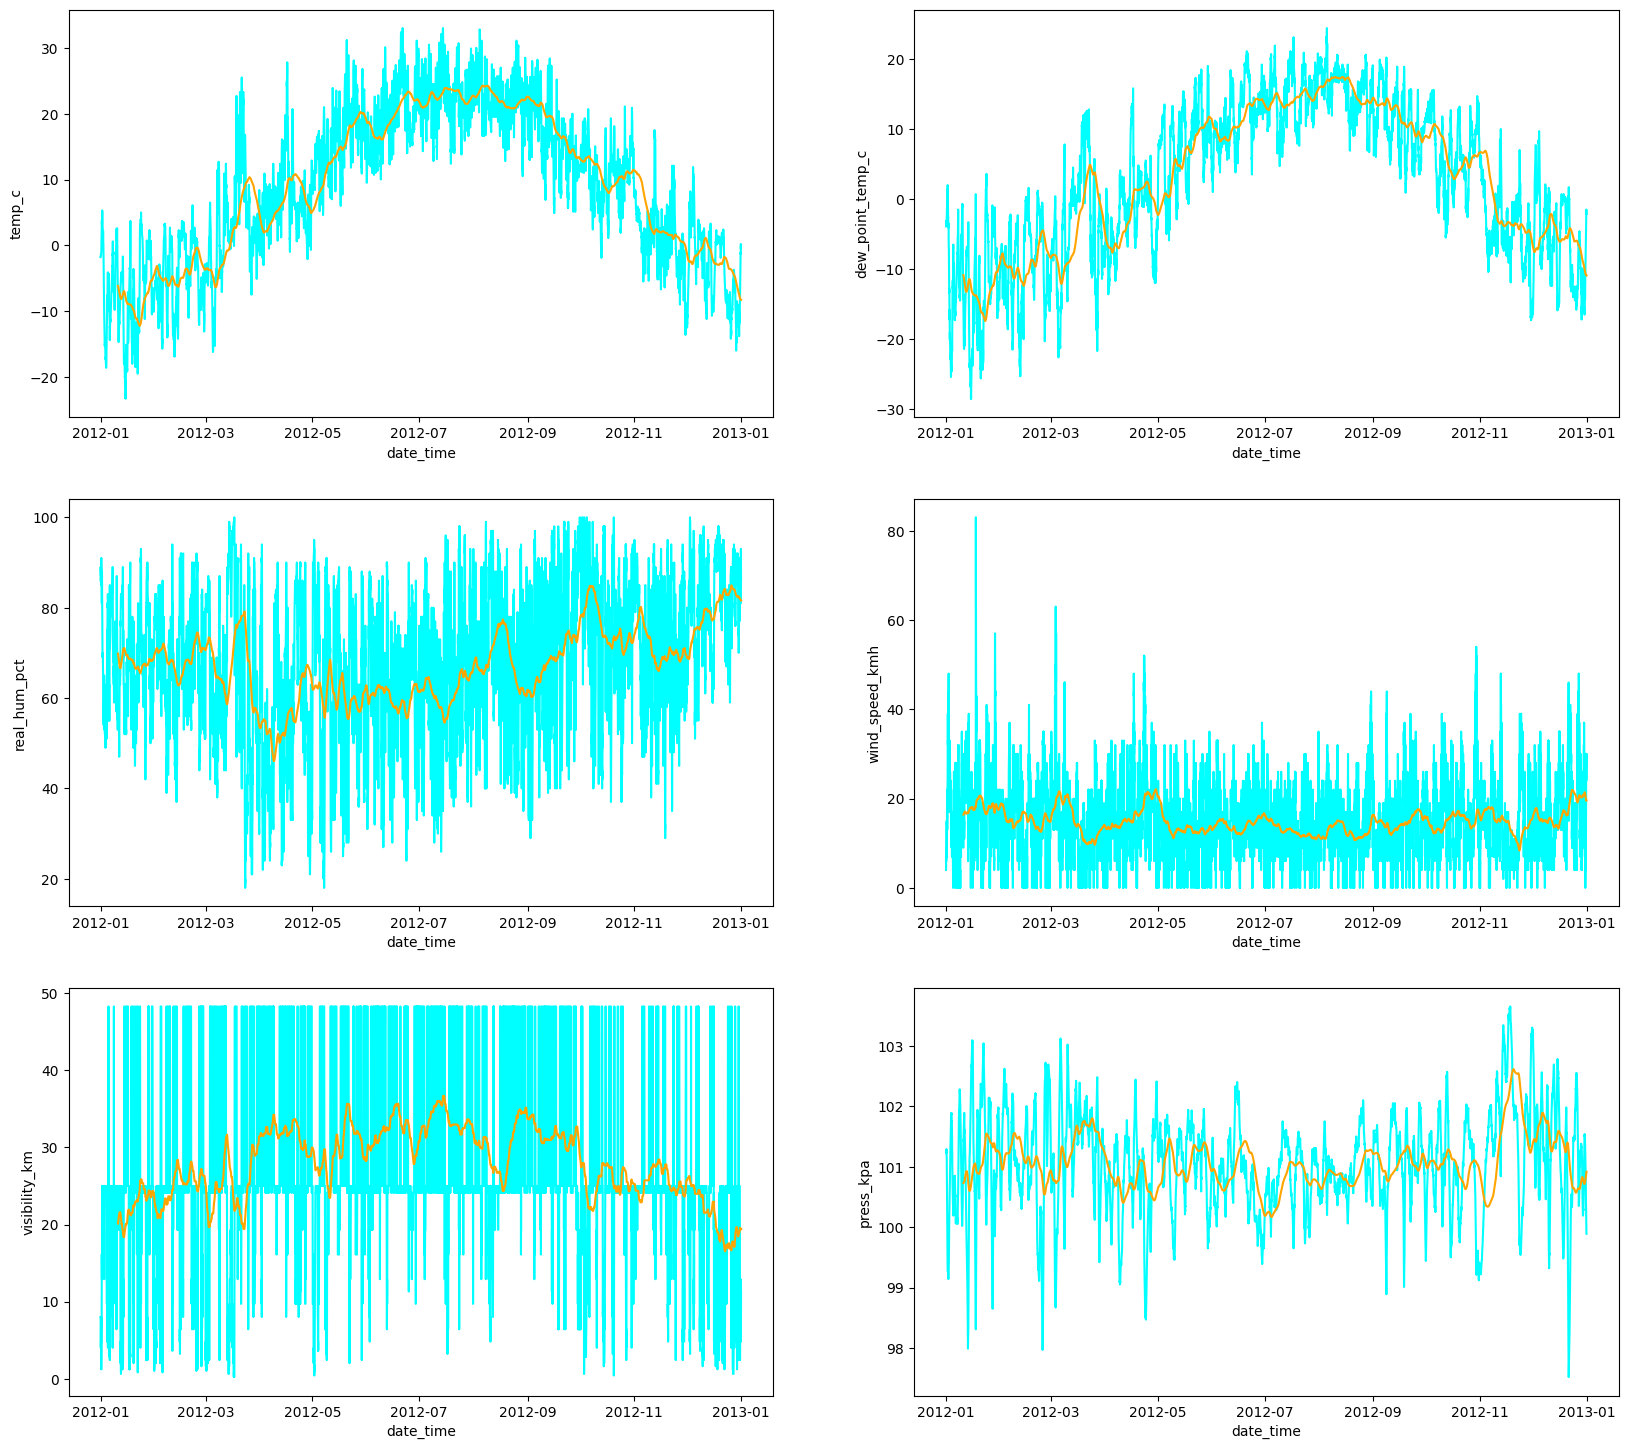

In [24]:
data_rolling = df.drop("weather", axis=1).rolling(240).mean()


plt.figure(figsize=(20, 18))
col = 1
for i in df.drop("weather", axis=1).columns:
    plt.subplot(3, 2, col)
    sns.lineplot(data=df, x="date_time", y=i, color="cyan")
    sns.lineplot(data=data_rolling, x="date_time", y=i, color="orange")
    col += 1

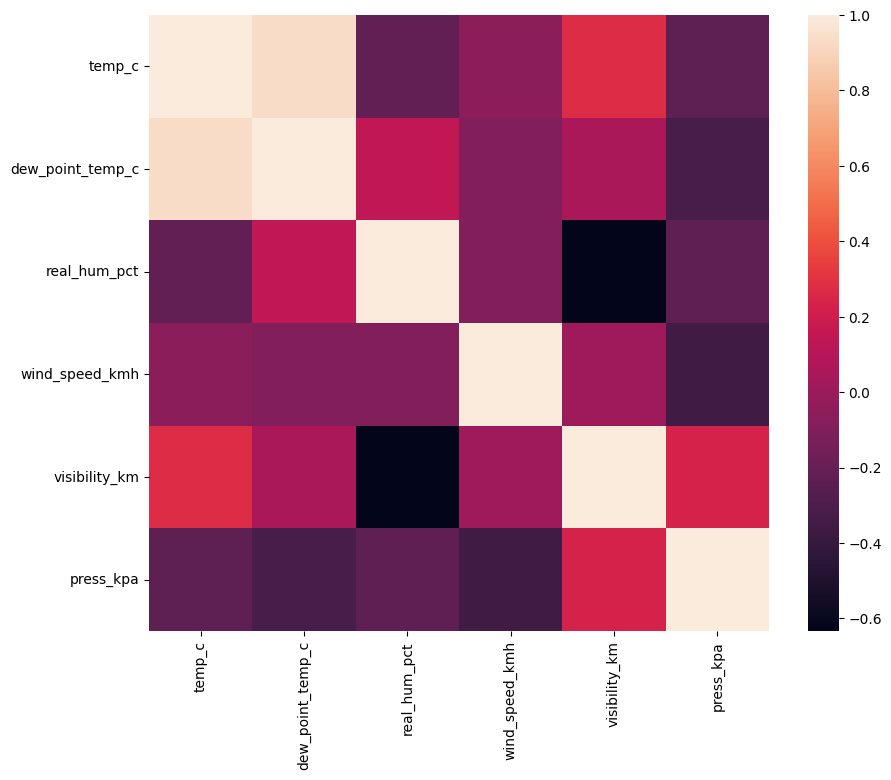

In [25]:
plt.figure(figsize=(10, 8))
sns.heatmap(df[df.columns[:6]].corr());

In [26]:
corpus = df["weather"]
vectorizer = CountVectorizer()
vectors = vectorizer.fit_transform(corpus)

weather_tfidf = pd.DataFrame(
    data=vectors.toarray(), index=corpus.index, columns=vectorizer.get_feature_names_out()
)
weather_tfidf.shape

(8784, 18)

In [27]:
weather_tfidf.sample(3)

,blowing,clear,cloudy,drizzle,fog,freezing,grains,haze,heavy,ice,mainly,moderate,mostly,pellets,rain,showers,snow,thunderstorms
date_time,,,,,,,,,,,,,,,,,,
2012-05-29 22:00:00,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2012-03-18 23:00:00,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
2012-01-30 15:00:00,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0


blowing


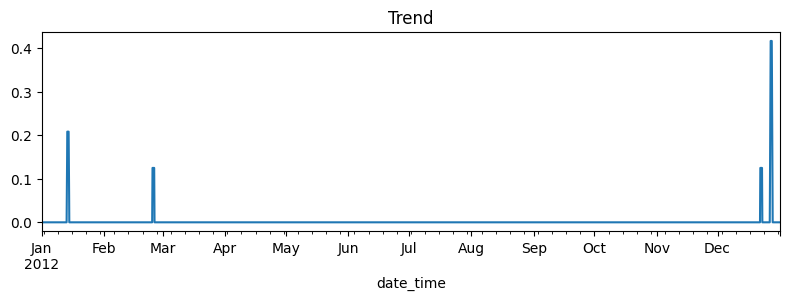

clear


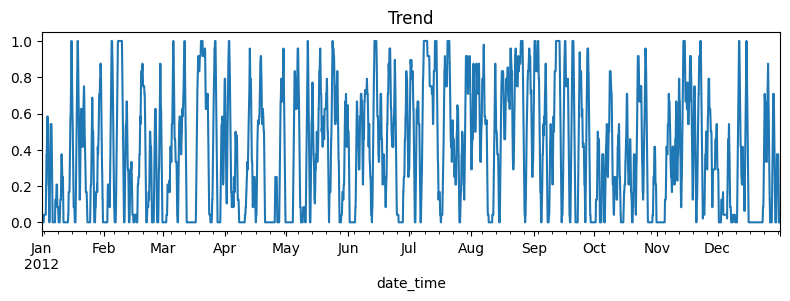

cloudy


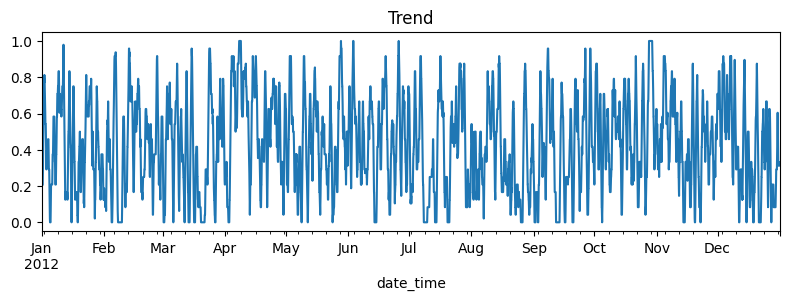

drizzle


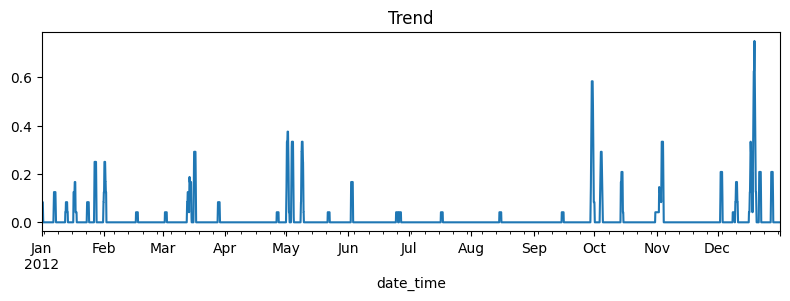

fog


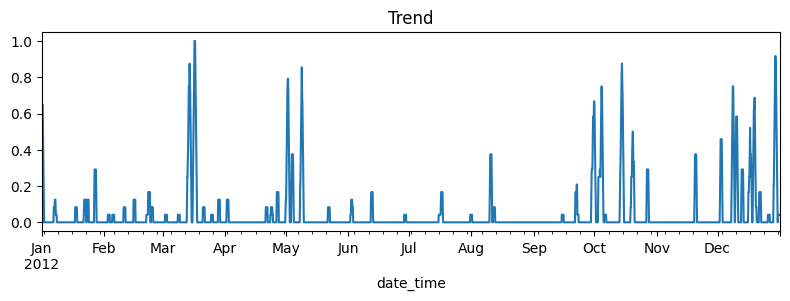

freezing


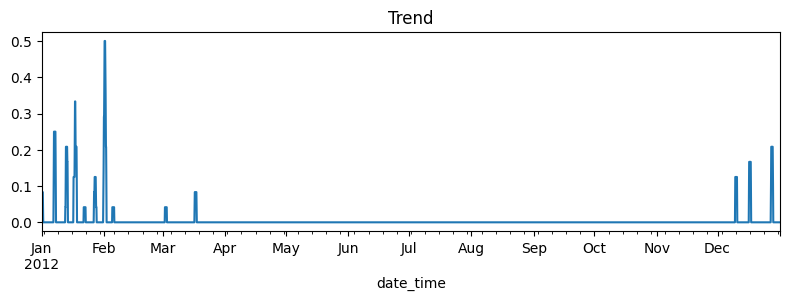

grains


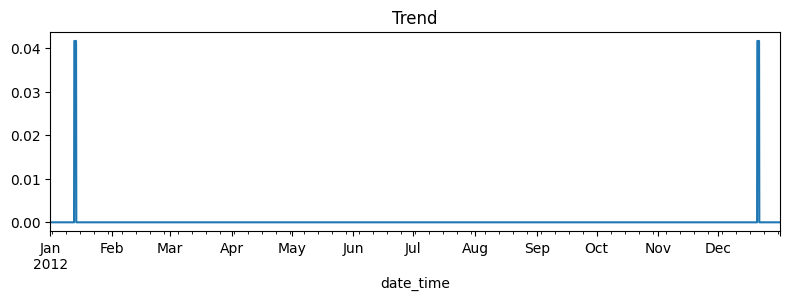

haze


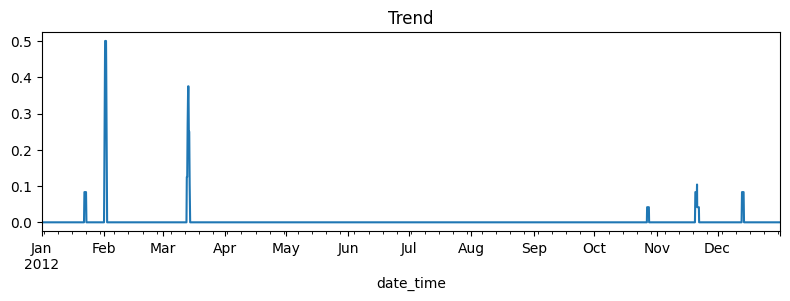

heavy


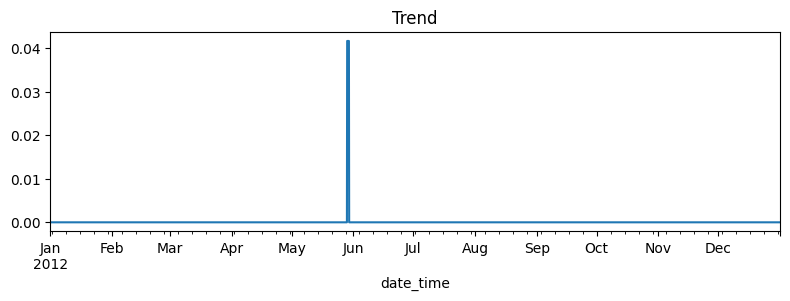

ice


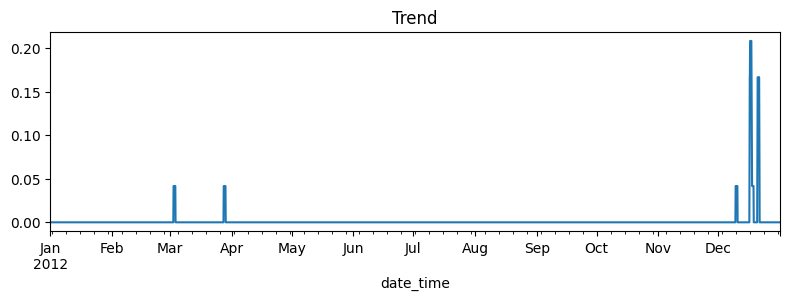

mainly


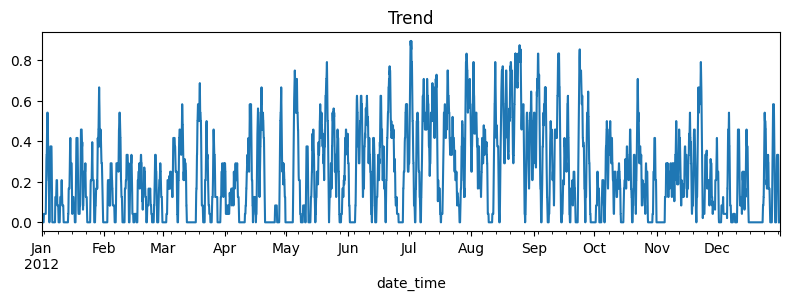

moderate


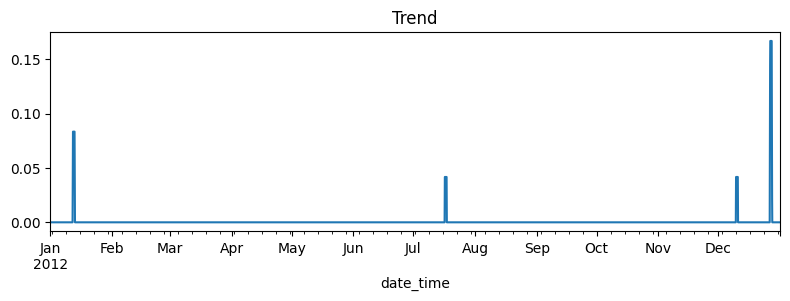

mostly


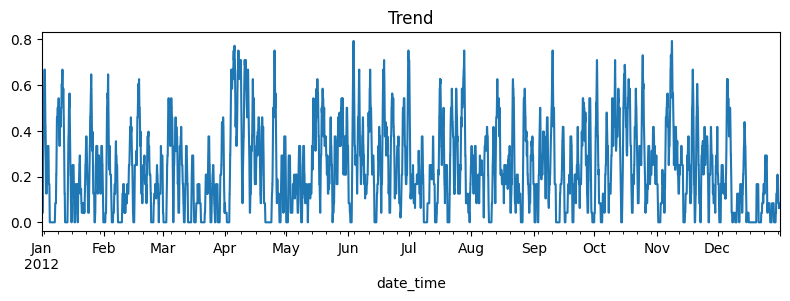

pellets


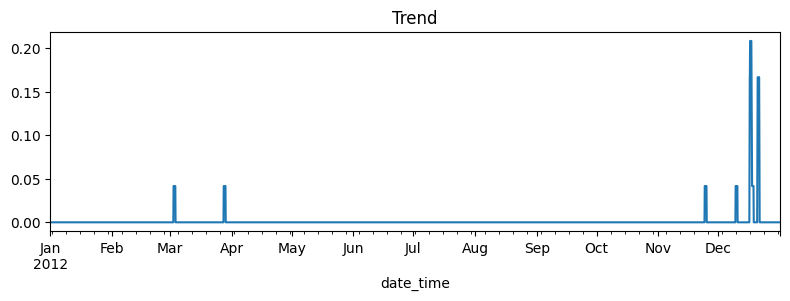

rain


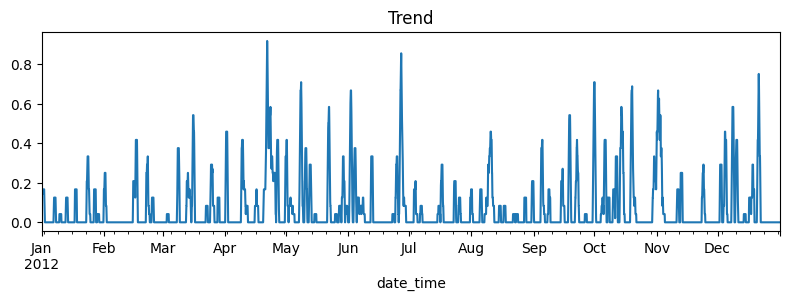

showers


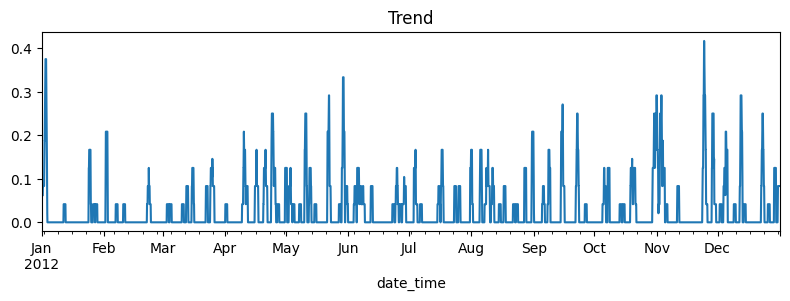

snow


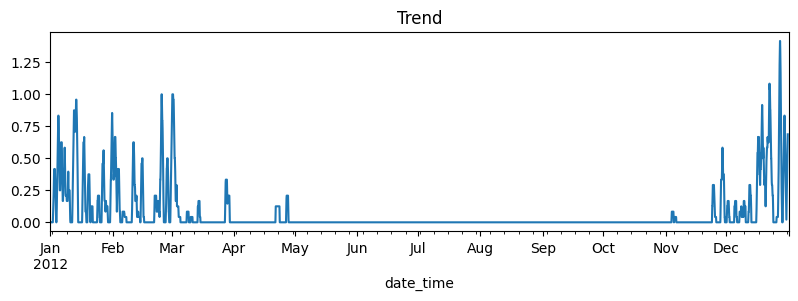

thunderstorms


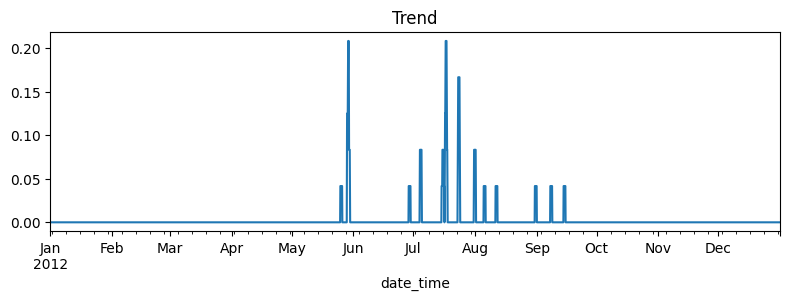

In [29]:
for i in weather_tfidf.columns:
    print(i)
    decomposed = seasonal_decompose(weather_tfidf[i])

    plt.figure(figsize=(8, 8))

    plt.subplot(311)
    decomposed.trend.plot(ax=plt.gca())
    plt.title("Trend")

    plt.tight_layout()
    plt.show()

In [30]:
weather_tfidf.drop(["mainly", "mostly", "moderate"], axis=1, inplace=True)

In [32]:
weather_col = list(weather_tfidf.columns)
weather_col.append("label")

metrics_col = list(df.drop("weather", axis=1).columns)
metrics_col.append("label")

X = df.drop("weather", axis=1)
df = X.join(weather_tfidf)
X = df.copy()
X = StandardScaler().fit_transform(X)

df.sample()

,temp_c,dew_point_temp_c,real_hum_pct,wind_speed_kmh,visibility_km,press_kpa,blowing,clear,cloudy,drizzle,...,freezing,grains,haze,heavy,ice,pellets,rain,showers,snow,thunderstorms
date_time,,,,,,,,,,,,,,,,,,,,,
2012-06-10 01:00:00,15.6,9.3,66,4,25.0,101.07,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
